In [3]:
# Phase 4: train/test model using random forest classifier comparing with old vs old and new features 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load Cleaned Data 
df = pd.read_pickle("../outputs/clean_data.pkl")

def output(X_train,y_test, y_pred, model):
    # Confusion Matrix 
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()



    # Feature Importance 
    feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_imp.sort_values().plot(kind='barh', figsize=(10, 6), title='Built-in Feature Importance (Random Forest)')
    plt.xlabel("Gini Importance")
    plt.tight_layout()
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9999    0.9995   2688312
           1     0.5672    0.1496    0.2367      2708

    accuracy                         0.9990   2691020
   macro avg     0.7832    0.5747    0.6181   2691020
weighted avg     0.9987    0.9990    0.9987   2691020



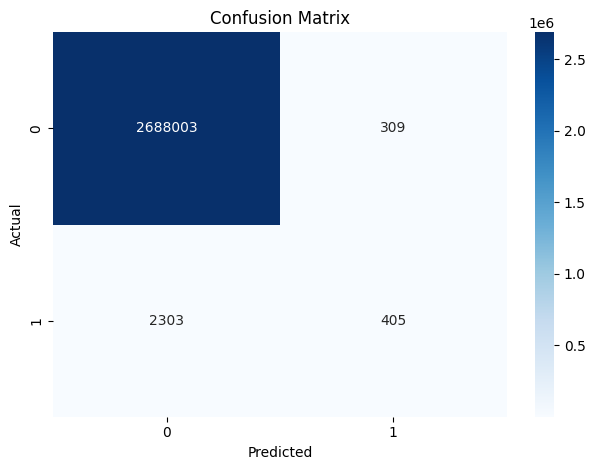

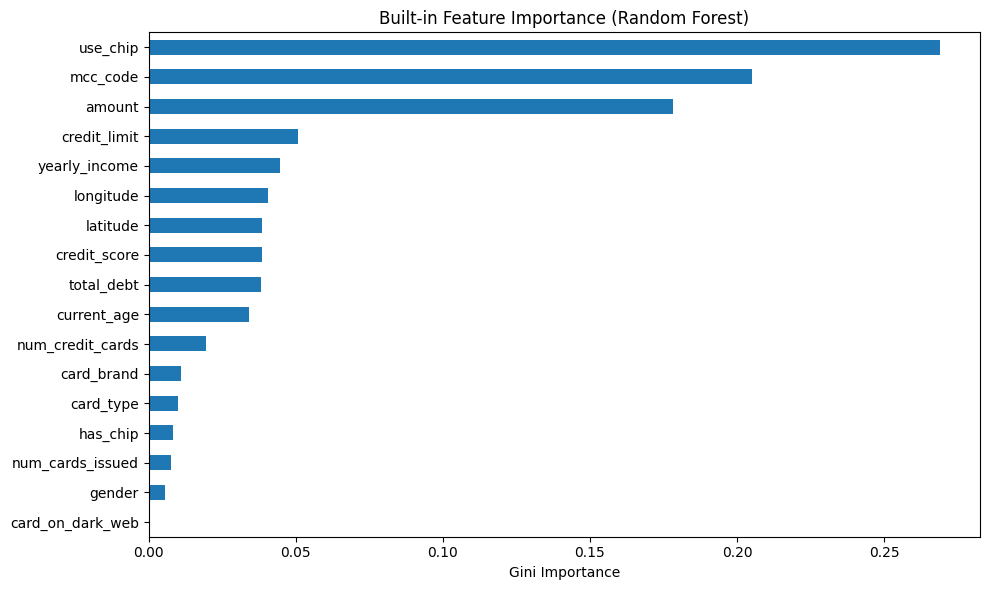

In [28]:
# Feature Selection (Using Raw Measures)

feature_cols = [
    'amount', 'use_chip', 'has_chip', 'card_on_dark_web', 'card_type', 'card_brand',
    'num_cards_issued', 'credit_limit', 'credit_score', 'yearly_income', 'total_debt',
    'current_age', 'gender', 'num_credit_cards', 'mcc_code', 'latitude', 'longitude'
]
X = df[feature_cols]
y = df["is_fraud"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest with Class Weights 
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluation 
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

output(X_train, y_test, y_pred, model)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, n_estimators=100; total time= 4.4min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=5, n_estimators=200; total time= 7.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=5, n_estimators=200; total time= 7.7min
[CV] END max_depth=10, max_features=log2, min_samples_leaf=5, n_estimators=200; total time= 7.7min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, n_estimators=100; total time= 4.4min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=5, n_estimators=100; total time= 7.6min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, n_estimators=300; total time=15.8min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=10, n_estimators=300; total time=15.8min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=10, n_estimators=300; total time=15.9min
[CV] END max_depth=20, max_features=sqrt, min

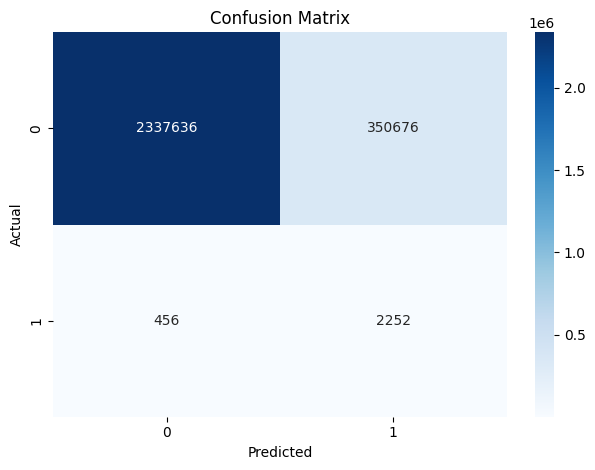

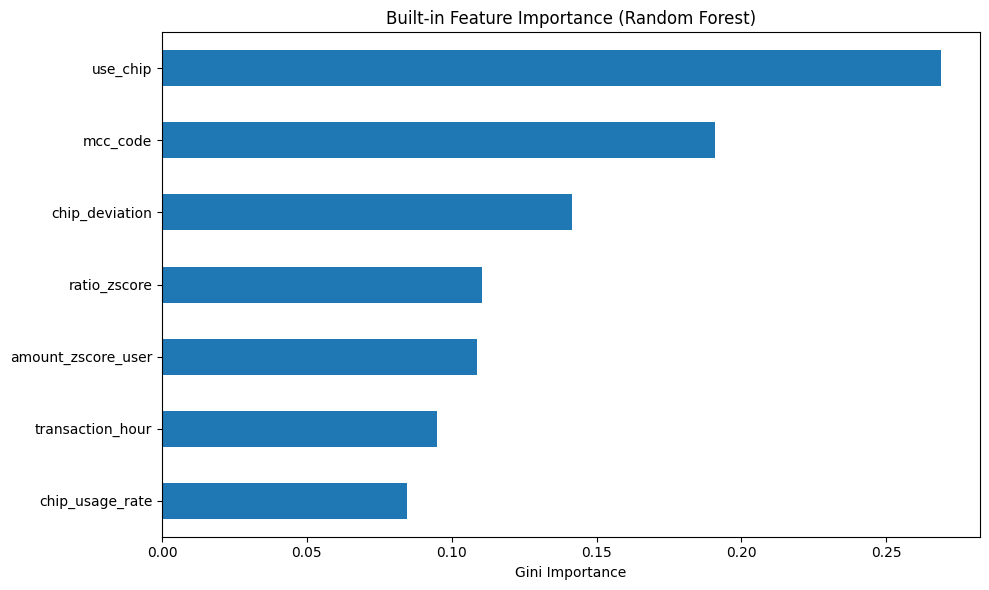

In [4]:
# Retrain model using feature engineering from Phase 3, dropping low importance features and fine tuning parameters using Randomized Search

# Load Updated Data with new features
df = pd.read_pickle("../outputs/refined_data.pkl")

feature_cols = [
    'use_chip', 'mcc_code', 'amount_zscore_user', 'chip_deviation', 'chip_usage_rate', 'ratio_zscore', 'transaction_hour'
]

X = df[feature_cols]
y = df["is_fraud"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train Random Forest with Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300], # Number of trees for stable predictions
    'max_depth': [10, 20], # Controls Overfitting
    'min_samples_leaf': [1, 5, 10], # Minimum samples allowed to have at leaf
    'max_features': ['sqrt', 'log2'], # Number of features to consider when looking for best split
    # 2 x 2 x 3 x 2 = 24 n_iter
}

base_model = RandomForestClassifier(class_weight='balanced_subsample', random_state=42, n_jobs=-1) # Subsample calculates the weights for each decision tree sample group

search = RandomizedSearchCV(
    base_model,
    param_distributions=param_grid,
    n_iter=12, # Number of random combinations to test
    scoring='recall', 
    cv=3, # 3 fold cross validation, splits training data into 3 folds
    verbose=2, # Prints progress during training
    random_state=42,
    n_jobs=-1
)
X_small = X_train.sample(frac=0.15, random_state=42)
y_small = y_train.loc[X_small.index]

search.fit(X_small, y_small)
best_model = search.best_estimator_

print("\nBest Parameters:", search.best_params_)

# Custom threshold:
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)  # threshold = 0.3 default threshold is .5

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

output(X_train, y_test, y_pred, best_model)






In [5]:
# Add predictions to the full dataset
df['fraud_proba'] = best_model.predict_proba(df[feature_cols])[:, 1]
df['fraud_pred'] = (df['fraud_proba'] >= 0.3).astype(int)

# Select columns to export
cols_to_export = [
    'transaction_id', 'date', 'amount', 'merchant_id', 'mcc_code',
    'use_chip', 'chip_usage_rate', 'chip_deviation',
    'amount_zscore_user', 'ratio_zscore', 'transaction_hour',
    'fraud_proba', 'fraud_pred', 'is_fraud'
]
df_tableau = df[cols_to_export]

# Export to CSV for Tableau
df_tableau.to_csv('../outputs/tableau/fraud_predictions_for_tableau.csv', index=False)
print("Exported predictions to Tableau")


Exported predictions to Tableau
